In [2]:
# 라이브러리 호출

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
# 데이터 전처리를 위해 사용하는 라이브러리
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
torch.cuda.empty_cache()

In [3]:
# CPU 혹은 GPU 장치 확인

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# fashion_mnist 데이터셋 내려받기

train_dataset = torchvision.datasets.FashionMNIST('./data', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
# 테스트 데이터셋 내려 받기
test_dataset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, 
                                                 transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



`torchvision.datasets`는 `torch.utils.data.Dataset`의 하위 클래스로 다양한 데이터셋을 포함함  

- 첫 번째 파라미터: FasionMNIST를 내려받을 위치를 지정  
- download: True라면 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인 후 내려 받음  
- transform: 이미지를 텐서(0~1)로 변경함  


In [5]:
# fashion_mnist 데이터를 데이터로더에 전달

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

`torch.utils.data.DataLoader()`를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가 무작위로 섞이도록 할 수 있음  

- 첫 번째 파라미터: 데이터를 불러올 데이터셋을 지정
- batch_size: 데이터를 배치로 묶어 줌, 위에서는 100 단위로 데이터를 불러옵니다.

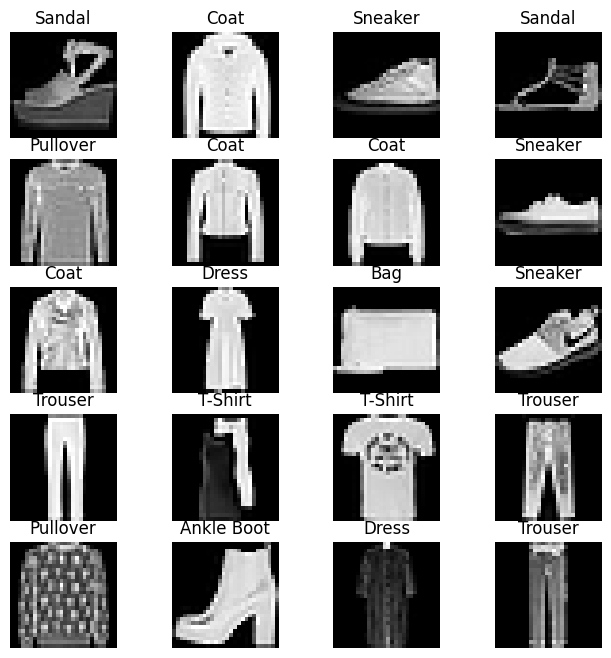

In [6]:
# 분류에 사용될 클래스 정의

# 열 개의 클래스
labels_map = {
    0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot',
}

# 출력할 이미지의 가로세로 길이 단위는 inch
fig = plt.figure(figsize=(8, 8))
columns, rows = 4, 5
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
# 20개의 이미지 데이터를 시각적으로 표현
plt.show()

`np.random`은 무작위로 데이터를 생성할 때 사용합니다.  
`np.random.randint()`는 이산형 분포를 갖는 무작위 표본을 추출할 때 사용  

``` python
import numpy as np

# 0 ~ 10의 임의의 숫자를 출력
np.random.randint(10)
> 2

# 1 ~ 9의 임의의 숫자를 출력
np.random.randint(1, 10)
> 1

# 0 ~ 1 사이의 정규표준분표 난수를 행렬로 (1 x 8) 출력
np.random.rand(8)
> array([0.89213233, 0.24661652, 0.73743451, ..., 0.25592822])

# 평균이 0이고, 표준편차가 1인 가우시안 정규분표 난수를 행렬로 (4 x 2) 출력
np.random.randn(4, 2)
> array([[-0.51816619, -0.91865557],
        ...,
        [1.40003186, -1.34076957],])
```

``` python
# train_dataset을 이용한 3차원 배열을 생성
import numpy as np

# 1~99의 숫자에서 3씩 건너뛴 행렬을 생성
examp = np.arange(0, 100, 3)
# 행렬의 크기를 6 x 4로 조정
examp.resize(6, 4)
examp
> array([[0, 3, 6, 9],
        [12, 15, 18, 21],
        ...,
        [60, 63, 66, 69]])

# 3행에 해당하는 모든 요소를 선택하고 출력
examp[3]
> array([36, 39, 42, 45])

# 3행의 3번재 열에 대한 값(요소)을 출력
examp[3, 3]
> 45

# 3행의 3번재 열에 대한 값(요소)을 출력하기 때문에 바로 앞의 결과와 동일
examp[3][3]
> 45
```

``` python
# 3차원 배열

examp = np.arange(0, 500, 3)
examp.resize(3, 5, 5)
examp
> array([[[0, 3, 6, 8, 12],
        ...,
        [60 , 63, 66, 69, 72]],

        [[75, 78, 81, 84, 87],
        ...,
        [135, 138, 141, 144, 147]],

        [[150, 153, 156, 159, 162],
        ...,
        [210, 213, 216, 219, 222]]])

examp[2][0][3]
> 159
```

In [7]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module):
    # 클래스 형태의 모델은 항상 torch.nn.Module을 상속 받음

    def __init__(self):
        # 부모 FasionDNN이라는 부모 클래스를 상속받겠다는 의미
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

`nn`은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지, Linear는 단순한 선형 회귀 모델을 만들 때 사용  

[파라미터]  
- in_features: 입력의 크기
- out_features: 출력의 크기

`torch.nn.Dropout(p)`는 p만큼의 비율로 텐서의 값이 0이 됨, 0이 되지 않은 값은 기존 값에 1/(1-p) 만큼 커짐  
> 아마도 과적합을 막기 위한 데이터 삭제에 대한 보상으로 보임  

`forward()`는 모델이 학습 데이터를 입력받아 순전파 학습을 진행하며, 반드시 forward라는 이름을 가져야 한다.  
객체를 데이터와 함께 호출하며 자동으로 실행됨  

pytorch에서 `view`는 넘파이의 `reshape`와 같은 역할(텐서의 크기 변경)  
input_data.view(-1, 784) = input_data를 (?, 784)의 크기로 변경하라는 것  
-1은 나는 잘 모르겠고, 파이토치가 알아서 해줘잉  

활성화 함수를 지정하는 방법은 크게 2가지  
- F.relu(): forward() 함수 안에서 정의
- nn.ReLu(): __init__ 함수에서 정의  
정의하는 위치와 사용 방법에 차이가 존재함  

``` python
# nn을 사용하는 코드

import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
# 세 개의 채널이 입력되어 64개의 채널이 출력되기 위한 연산으로 3 x 3 크기의 커널을 사용
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1, 1, 3)
```

``` python
# nn.functional을 사용하는 코드

import torch.nn.functional as F

inputs = torch.randn(64, 4, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)
```

`nn.Conv2d`에서 `input_channels`와 `output_channels`을 사용해서 연산  
`functional.conv2d`는 입력과 가중치 자체를 직접 상수로 넣어줌  
> 가중치를 전달해야 할 때마다 값을 새로 정의해야 함을 의미  

그 외에는 비슷함   

In [8]:
# 심층 신경망에서 필요한 파라미터 정의

learning_rate = 0.001
model = FashionDNN()
model.to(device)

# 분류 문제에서 사용하는 손실 함수
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


옵티마이저를 위한 경사 하강법은 Adam을 사용하며, 학습률을 의미하는 lr은 0.001을 사용한다는 의미  

In [9]:
# 심층 신경망을 이용한 모델 학습

num_epochs, count = 5, 0
loss_list, iteration_list, accuracy_list = [], [], []
predictions_list, labels_list = [], []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 모델이 데이터를 처리하기 위해서 모델과 데이터가 동일한 장치(CPU 혹은 GPU)에 있어야 한다.
        images, labels = images.to(device), labels.to(device)

        # 자동 미분을 수행하는 파이토치의 핵심 패키지, 순전파 단계에서 테이프는 수행하는 모든 연산을 저장
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # 학습 데이터를 모델에 적용
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
        if not (count % 50):
            total, correct = 0, 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
        
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}')


Iteration: 500, Loss: 0.5968182682991028, Accuracy: 83.22999572753906
Iteration: 1000, Loss: 0.4616239070892334, Accuracy: 84.2699966430664
Iteration: 1500, Loss: 0.3567803204059601, Accuracy: 84.37999725341797
Iteration: 2000, Loss: 0.3761325776576996, Accuracy: 85.27999877929688
Iteration: 2500, Loss: 0.2811490297317505, Accuracy: 85.68999481201172
Iteration: 3000, Loss: 0.2553606331348419, Accuracy: 86.54999542236328


[배열이나 행렬같은 리스트를 사용하는 방법]  
1. 비어있는 행렬이나 배열을 만듦
2. append() 메서드를 통해 데이터를 하나씩 추가

분류 문제에 대한 정확도는 정확한 예측 / 전체 예측  

`classfication accuracy = correct prediction / total predictions`  
`error rate = (1 - (correct predictions / total predictions)) * 100`  

분류 문제에서 클래스가 3개 이상일 대 다음과 같은 사하아에 주의할 것  
- 정확도가 80% 이상: 모든 클래스가 동등하게 80% 이상이 아닐 수도 있다.(분산이 클 수도 있다.)
- 정확도가 90% 이상: 100개의 데이터 중 90개의 데이터가 하나의 클래스에 속한다면, 그 정확도는 보장할 수 없다.
> 데이터 특성에 따른 정확도를 잘 관측해야 함  


In [10]:
# 합성곱 네트워크 생성

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Sequential은 계층을 차례로 쌓을 수 있게 Wx + b와 같은 수식과 활성화 함수를 연결하는 역할
        # 여러 개의 계층을 하나의 컨테이너 안에 구현하는 방식
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 이미지 형태의 데이터를 배열 형태로 변환하여 작업
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # 마지막 계층의 out_feafures는 클래스 개수를 의미
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꿔 줌
        # 64 * 6 * 6, (64*6*6, -1)로 크기를 변경, 행의 수는 정확히 알고 있지만, 열의 수는 알지 못할 때 사용
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


합성곱층은 합성곱 연산을 통해 이미지의 특징을 추출  
커널(필터)라는 n x m 크기의 행렬이 이미지의 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력  
커널은 일반적으로 3 x 3, 5 x 5  

[Conv2d의 파라미터]  
- in_channels: 입력 채널의 수, 흑백이미지는 1, RGB 이미지를 가진 이미지는 3
- out_channels: 출력 채널의 수
- kernel_size: 커널의 크기(필터), CNN에서 학습 대상은 필터 파라미터, 이 값이 (3, 5)이면 3 x 5 크기의 직사각형
- padding: 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움, 패딩 값이 클수록 출력 크기도 커짐  

`BatchNorm2d`: 학습 과정에 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것  

`MaxPool2d`: 이미지 크기를 축소하는 용도  
풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아 출력 데이터의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용  
  - kernel_size: m x n 행렬로 구성된 가중치
  - stride: 입력 데이터에 커널(필터)를 적용할 때 이동할 간격, 값이 커지면 출력 크기는 작아짐

`Conv2d`에서 사용한 하이퍼파라미터의 값에 따라 출력 크기가 달라지고 이것은 최종적으로 분류를 담당하는 완전연결층에 전달  
 

In [11]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
# 모델 학습 및 성능 평가
num_epochs, count = 5, 0
loss_list, iteration_list, accuracy_list = [], [], []

predictions_list, labels_list = [], []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # 모델을 입력 데이터에 적용(입력 샘플에 대한 예측 결과 계산)
        outputs = model(train)
        # criterion: 손실 함수
        loss = criterion(outputs, labels)
        # 모든 모델 파라미터의 그래디언트를 초기화
        optimizer.zero_grad()
        # 자동 미분을 사용하여 손실에 대한 모델 파라미터의 그래디언트 계산
        loss.backward()
        # 옵티마이저는 계산된 그래디언트를 기반으로 모델 파라미터를 업데이트
        optimizer.step()
        count += 1

        if not (count % 50):
            total, correct = 0, 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                # outputs 텐서의 두 번째 차원에 따라 최댓값 계산, 결과는 2개의 텐서를 담은 튜플  
                # 첫 번째는 각 입력 샘플에 대한 최댓값, 두 번째는 최댓값에 해당하는 인덱스 (클래스 레이블)
                # 여기서 [1]을 통해 클래스 인덱스를 추출함
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}')

C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4586273431777954, Accuracy: 87.55999755859375
Iteration: 1000, Loss: 0.3318825662136078, Accuracy: 87.62999725341797
Iteration: 1500, Loss: 0.3609088957309723, Accuracy: 86.18999481201172
Iteration: 2000, Loss: 0.23161298036575317, Accuracy: 89.6500015258789
Iteration: 2500, Loss: 0.13334721326828003, Accuracy: 89.45999908447266
Iteration: 3000, Loss: 0.1845787763595581, Accuracy: 90.18000030517578


In [13]:
# 라이브러리 호출

# > pip install opencv-python
import os
import time
import copy
import glob
# OpenCV 라이브러리
import cv2
import shutil

import torch
# 컴퓨터 비전 용도의 패키지
import torchvision
# 데이터 전처리를 위해 사용하는 패키지
import torchvision.transforms as transforms
# 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torchvision.models as models
import torch.nn as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [14]:
# 이미지 데이터 전처리 방법 정의

# 이미지 데이터가 위치한 경로 지정
data_path = './data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True,
)

print(len(train_dataset))

385


`torchvision.transform`은 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환해 줌  

[파라미터]  
- Resize: 이미지의 크기를 조절, 256 x 256 크기로 이미지 데이터를 조정
- RandomResizedCrop: 이미지를 랜덤한 크기 및 비율로 자름

Resize는 합성곱층을 통과하기 위해 이미지 크기를 조정하는 과정  
RandomResizedCrop은 이미지를 랜덤한 비율로 자른 후 데이터 크기를 조정함  

- RandomHorizontalFlip: 이미지를 랜덤하게 수평으로 뒤집음
- ToTensor: 이미지 데이터를 텐서로 변환


`datasets.ImageFolder`: 데이터로더가 데이터를 불러올 대상(경로)과 방법(전처리)을 정의함  

[파라미터]  
- 첫 번째 파라미터: 불러올 데이터가 위치한 경로  
- transform: 이미지 데이터에 대한 전처리

`DataLoader`: 데이터를 불러오는 부분  

[파라미터]  
- 첫 번째 파라미터: 데이터셋을 지정
- batch_size: 한 번에 불러올 데이터 양을 결정하는 배치 크기 설정
- num_workers: 데이터를 불러올 때 하위 프로세스를 몇 개 사용할 지 설정, 너무 많으면 오류가 발생하거나 메모리가 부족해진다.  
- shuffle: 데이터를 무작위로 섞을 지 boolean으로 설정

torch.Size([32, 3, 224, 224])


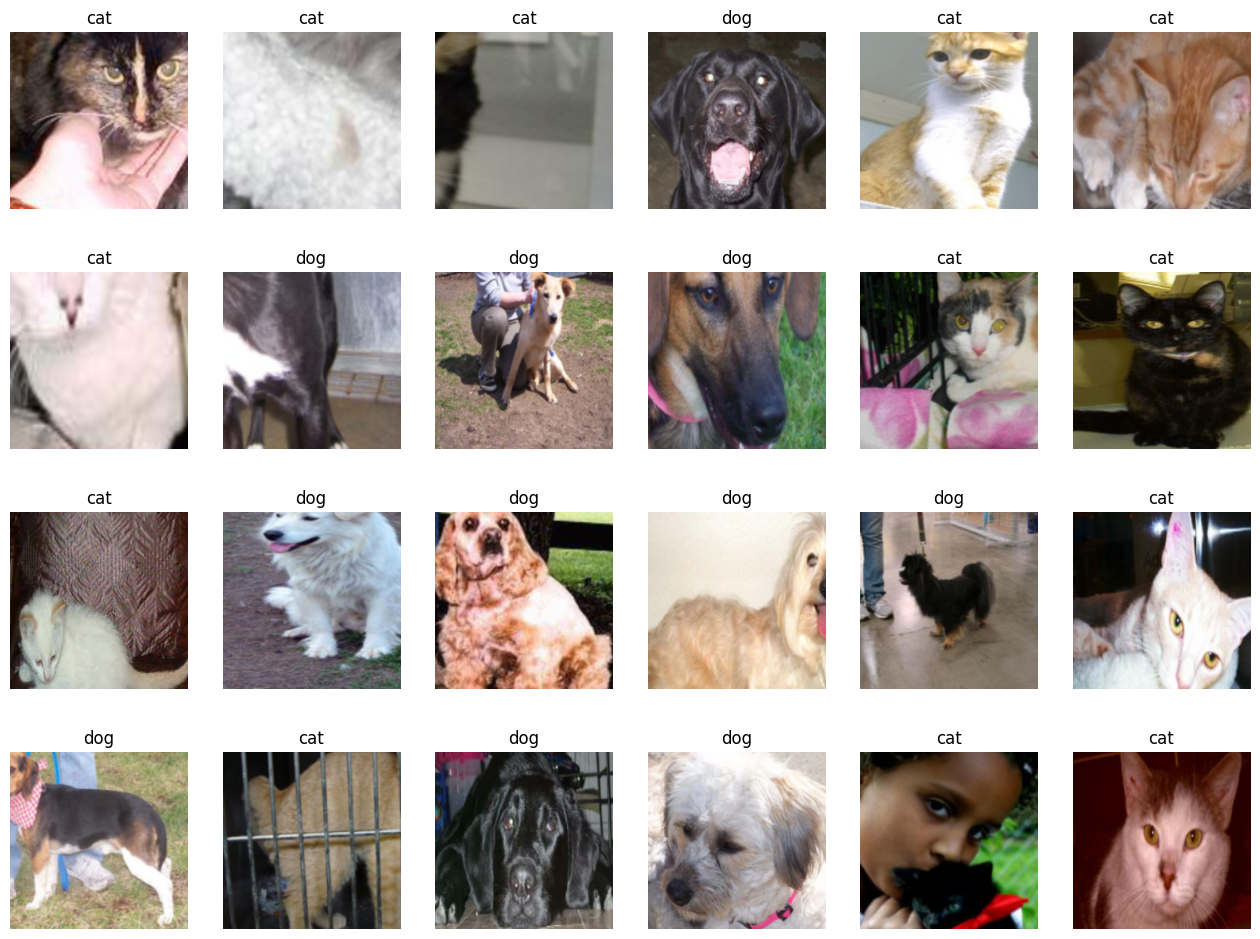

In [17]:
# 학습에 사용할 이미지 출력

#
samples, labels = next(iter(train_loader))
# 개와 고양이에 대한 클래스로 구성
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16, 24))

# 24개의 이미지 데이터 출력
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    # 레이블 정보(클래스)를 함께 출력
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

반복자(iterator)를 사용하려면 `iter()`와 `next()`가 필요함  
`iter()`는 전달된 데이터의 반복자를 꺼내 반환하며, `next()`는 그 반복자가 다음에 출력해야 할 요소를 반환함

`np.transpose`는 행과 열을 바꾸어 행렬의 차원을 변경함  
행렬의 차원을 변경하는 이유: 행렬의 내적 연산 때문  
두 행렬의 내적은 A행렬의 행과 B행렬의 열을 곱한 것을 모두 더한 값으로 구성되는데 행과 열의 크기가 일치하지 않으면 성립이 되지 않는다.  
이 때, `np.transpose()`나 `np.reshape()` 등으로 차원을 조정해야 한다.  

``` python
exam = np.arange(24).reshape(2, 3, 4)
exam
> array([[[0, 1, 2, 3],
        [4, 5, 6, 7],
        [8, 9, 10, 11],

        ...,
        [20, 21, 22, 23]]])

# (2, 3, 4)크기를 (4, 3, 2)로 변환
# 2번 축이 0번을, 1번 축이 1번을, 2번 축이 0을 사용
np.transpose(exam, (2, 1, 0))
> array([[[0, 12],
          [4, 16],
          [8, 20], 
          
          ...,
          [11, 23]]])
```

`torch.Size([32, 3, 224, 224])`  
- 32: 배치 크기, 모델은 한 번에 여러 개의 이미지를 처리하는데 여기서 한 번에 처리되는 이미지의 개수, 속도와 메모리 성능에 영향
- 3: 채널
- 224: 이미지의 가로와 세로 크기, 일반적으로 224는 딥러닝 모델에서 많이 사용되는 크기

`iter(train_loader).next()`: _MultiProcessingDataLoaderIter 객체에 next() 속성이 없다 = 파이썬의 `next()` 함수는 `__next()__`를 호출  
그러므로 `next(iter(train_loader))`를 사용해야 한다.

In [18]:
# 사전 훈련된 모델 내려받기

# 'pretrained=True'는 사전 학습된 가중치를 사용하겠다는 의미
resnet18 = models.resnet18(pretrained=True)

C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\leegyuseok/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


ResNet18: 50개의 계층으로 구성된 합성곱 신경망  
ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망으로 전이 학습에 사용되도록 사전 훈련된 모델을 제공하고 있음
하지만, ResNet18은 입력 제약이 너무 크고, 충분한 메모리가 없으면 학습 속도가 느릴 수 있는 단점이 존재  

``` python
# 파이토치를 통해 무작위의 가중치로 모델을 구성하는 방법
import torchvision.models as models

resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()
```

``` python
# 사전 학습된 모델의 가중치 값을 사용하기
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)
```

In [ ]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.prameters():
            # 역전파 중 파라미터에 대한 변화를 계산할 필요가 없음을 나타냄
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

모델의 일부(합성곱층, 풀링층)를 고정하고 나머지를 학습할 때 `requires_grad = False`로 설정

In [19]:
# ResNet18에 완전연결층 추가

# 클래스가 2개다, fc: Fully Connected Layer(네트워크의 마지막 개수), 512: 입력 차원 수
resnet18.fc = nn.Linear(512, 2)

In [20]:
# 모델의 파라미터 값 확인

# model.name_parameters()는 모델에 접근하여 파라미터 값을 가져올 때 사용
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        # y = Wx + b에서 W는 weight, b는 bias
        print(name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

In [21]:
# 모델 객체 생성 및 손실 함수 정의

# 모델 객체 생성
model = models.resnet18(pretrained=True)

# 모델의 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
# 완전 연결층은 학습
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
# 손실 함수 정의
cost = torch.nn.CrossEntropyLoss()
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# 모델 학습을 위한 함수 생성

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    # 컴퓨터의 현재 시각을 구하는 함수
    since = time.time()
    # 모델의 정확도, 오차
    acc_history, loss_history = [], []
    best_acc = 0.0

    # 에포크 만큼 반복
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        running_loss, running_corrects = 0.0, 0

        # 데이터 로더에 전달된 데이터만큼 반복
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            # 기울기를 0으로 설정
            optimizer.zero_grad()
            # 순전파 학습
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            # 역전파 학습
            loss.backward()
            optimizer.step()

            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_loss += loss.item() * inputs.size(0)
            # 출력 결과와 레이블이 동일한 지 확인한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)

        # 평균 오차 계산
        epoch_loss = running_loss / len(dataloaders.dataset)
        #  평균 정확도 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        # 모델 재사용을 위해 저장해 둠
        
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', f'{epoch:02d}.pth'))
        print()
    
    # 실행 시간(학습 시간)을 계산
    time_elapsed = time.time() -since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}')
    # 소수점 이하 4자리까지 표현하는 방식
    print(f'Best Acc: {best_acc:.4f}')
    return acc_history, loss_history

`torch.save()`는 pytorch 모델을 저장하는 함수  
pth는 파일 확장자, :02d 는 정수를 2자리로 표시하고 필요한 경우 앞을 0으로 채우는 문자열 포맷팅  

`model_state_dict()`는 모델의 가중치를 담고 있는 딕셔너리  

`zero_grad()`는 기울기를 0으로 설정하는 역할을 수행, 역전파 단계에서 이전 학습의 영향을 현재 순전파 학습에 반영하지 않도록 하기 위해 사용  

`torch.max()`는 텐서 내의 최대값과 해당 최대값의 인덱스를 반환  
  - torch.max(input): 입력 텐서 내의 모든 요소 중 최대값을 반환
  - torch.max(input, dim): 지정된 차원에서 각 행의 최대값과 해당 최대값의 인덱스를 반환, 형식은 namedtuple 형태로 values와 index로 구성
  
`epoch_acc`를 계산할 때, running_corrects에 double(), 부동소수점을 하는 이유는 정확도를 계산할 대 소수점 이하 자리 수를 포함하기 위해서  


In [26]:
# 파라미터 학습 결과를 옵티마이저에 전달
# torch.Adam이 아닌 torch.optim.Adam을 사용해야 함

params_to_update = []
for name, param in resnet18.named_parameters():
    # 학습을 시키겠다.
    if param.requires_grad == True:
        # 파라미터 학습 결과를 저장
        params_to_update.append(param)
        print('\t', name)

# 학습 결과를 옵티마이저에 전달
optimizer = torch.optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [27]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 손실 함수 지정
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Loss: 0.6737 Acc: 0.7299

Epoch 1/12
----------
Loss: 0.5301 Acc: 0.7610

Epoch 2/12
----------
Loss: 0.4188 Acc: 0.8078

Epoch 3/12
----------
Loss: 0.4414 Acc: 0.7948

Epoch 4/12
----------
Loss: 0.4150 Acc: 0.7896

Epoch 5/12
----------
Loss: 0.3871 Acc: 0.8338

Epoch 6/12
----------
Loss: 0.3791 Acc: 0.8234

Epoch 7/12
----------
Loss: 0.3311 Acc: 0.8364

Epoch 8/12
----------
Loss: 0.3081 Acc: 0.8701

Epoch 9/12
----------
Loss: 0.3220 Acc: 0.8494

Epoch 10/12
----------
Loss: 0.3018 Acc: 0.8390

Epoch 11/12
----------
Loss: 0.2523 Acc: 0.8935

Epoch 12/12
----------
Loss: 0.3269 Acc: 0.8416

Training complete in 1m 51
Best Acc: 0.8935


In [29]:
# 테스트 데이터 호출 및 전처리

test_path = './data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        # 중앙 부분을 유지하고 224 x 224 크기의 이미지로 만듦
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True,
)

print(len(test_dataset))


98


In [32]:
# 테스트 데이터 평가 및 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    # glob: 현재 원하는 파일을 추출하여 가져올 때 사용
    # pth 확장자를 가진 모든 파일을 가져오거라
    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    # 불러온 .pth 파일을 정렬, 특정 시점의 모델을 쉽게 선택하여 평가할 수 있기에 정렬
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        # 모델을 평가 모드로 전환
        # 평가 모드가 되면 드롭아웃 비활성화, 배치 정규화의 이동 평균과 분산이 업데이트 되지 않음
        model.eval()
        model.to(device)
        running_corrects = 0

        # 테스트 반복
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # autograd를 사용하지 않겠다는 의미
            with torch.no_grad():
                # 데이터를 모델에 적용한 결과를 outputs에 저장
                outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            # torch.max로 출력된 값이 0.5와 같거나 크면 올바르게 예측
            preds[preds >= 0.5] = 1
            # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            preds[preds< 0.5] = 0
            # preds 배열과 labels 배열이 일치하는지 검사하는 용도로 사용
            running_corrects += preds.eq(labels).int().sum()

        # 테스트 데이터의 정확도 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc:.4f}')


        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()
    
    time_elapsed = time.time() - since
    print(f'Validatation complete in {time_elapsed / 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}')

    # 계산된 정확도 반환
    return acc_history

In [33]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth


C:\Users\leegyuseok\anaconda3\envs\torch_book\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Acc: 0.7245

Loading model ./data/catanddog\01.pth
Acc: 0.6020

Loading model ./data/catanddog\02.pth
Acc: 0.6837

Loading model ./data/catanddog\03.pth
Acc: 0.7959

Loading model ./data/catanddog\04.pth
Acc: 0.7041

Loading model ./data/catanddog\05.pth
Acc: 0.7755

Loading model ./data/catanddog\06.pth
Acc: 0.7245

Loading model ./data/catanddog\07.pth
Acc: 0.8776

Loading model ./data/catanddog\08.pth
Acc: 0.8571

Loading model ./data/catanddog\09.pth
Acc: 0.7041

Loading model ./data/catanddog\10.pth
Acc: 0.8265

Loading model ./data/catanddog\11.pth
Acc: 0.7653

Loading model ./data/catanddog\12.pth
Acc: 0.7959

Validatation complete in 1m 47s
Best Acc: 0.8776


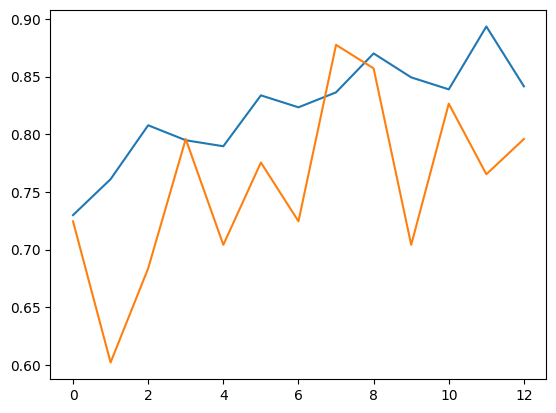

In [34]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

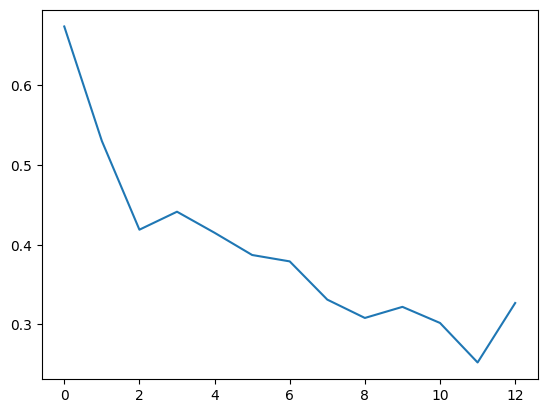

In [35]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [39]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

`tensor.clone()`: 기존 텐서의 내용을 복사한 텐서를 생성  
`detach()`: 기존 텐서에서 기울기가 전파되지 않는 텐서  
`tensor.clone().detach()`: 기존 텐서를 복사한 새로운 텐서를 생성하지만, 기울기에 영향을 주지 않겠다.  

계산 그래프: 계산 과정을 그래프로 나타낸 것, 노드와 에지로 이루어진다.  
`clip()`: 입력 값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용함  
`image.clip(0, 1)`은 image 데이터를 0과 1 사이의 값으로 제한하겠다.  


``` python
# np.clip() 활용

import numpy as np
exam = np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam, -0.5, 0.5))

> [-1.8 -1.2 -0.7 0. 0.8 1.4 1.9]
> [-0.5 -0.5 -0.5 0. 0.5 0.5 0.5]

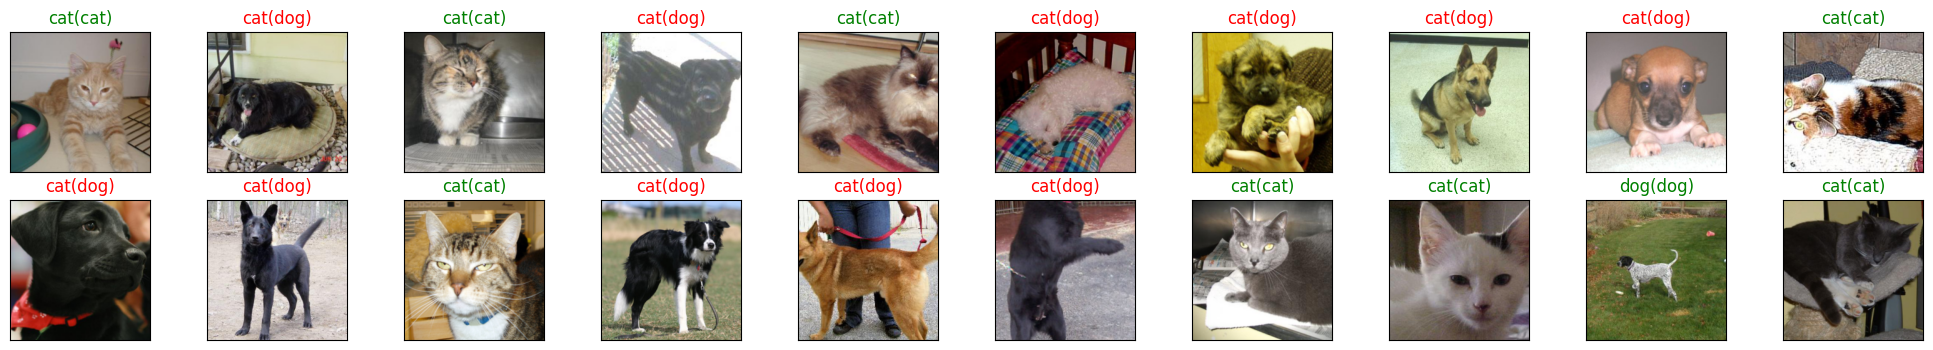

<Figure size 640x480 with 0 Axes>

In [42]:
# 개와 고양이 예측 결과 출력

classes = {0: 'cat', 1: 'dog'}

# 테스트 데이터셋
dataiter = iter(test_loader)
# 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져 옴
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    # 이미지 출력을 위해 im_convert 함수를 적용
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    # classes[preds[idx].item()]: preds[idx].item() 값이 classes로 정의된 0과 1 중 어떤 값을 갖는지 판별하겠다
    ax.set_title(f'{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})', color=('green' if preds[idx]==labels[idx] else 'red'))
    
plt.show()
# hspace, wspace: 서브플롯 간 간격 (너비와 높이의 비율), left, bottom, right, top 등으로 이미지의 위치를 조정
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

`add_subplot`은 한 화면에 여러 개의 이미지를 담기 위해 사용  
  - 첫 번째 파라미터: 행의 수를 의미
  - 두 번째 파라미터: 열의 수를 의미
  - 세 번째 파라미터: 인덱스를 의미, 행과 열을 기준으로 순차적으로 이미지를 출력
  - 네 번째 파라미터: x, y 축의 눈금(tick), 빈 리스트라는 것은 이를 삭제하겠다는 의미

잘 예측을 하지는 못 하지만, 훈련 데이터를 늘리고 에포크 횟수도 늘리면 좋은 결과를 얻을 수 있을 것
